In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys

from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    if 1 in hand and sum(hand) + 10 <= 21:
        return 1
    else:
        return 0


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


# modified from a class I found through the OpenAI Gym website
class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    cards are drawn from an infinite deck so there is no advantage to remembering cards
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    The reward for winning is +1, drawing is 0, and losing is -1.
    The observation of a 3-tuple of:
        - the players current hand value (4-20, mapped to 0-16)
        - the dealer's one showing card (1-10 where 1 is ace, mapped to 0-9)
        - whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    """
    def __init__(self):
        super(BlackjackEnv, self).__init__()
        
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(18),  # 4-21 are the possible hand values for a player (since A-2 counts as 13)
            spaces.Discrete(10),  # 1-10 are possible upcards for dealer(Ace = 1)
            spaces.Discrete(2)))  # 0 = stay, 1 = hit
        
        self.done = False
        
        self.seed()

        # initialize hands as empty 
        self.player = []
        self.dealer = []
        
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _take_action(self, action):
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
        
        # update value of player's hand after any changes   
        self.player_value = sum_hand(self.player)
            
    def step(self, action):
        
        info = {}
        # take the action
        assert self.action_space.contains(action)
        self._take_action(action)
        
        if is_bust(self.player):
            self.done = True
            rewards = -1.
        
        elif action == 0:
        # we're done taking cards but haven't busted and now it's the dealer's turn
            self.done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            # win or lose
            rewards = cmp(score(self.player), score(self.dealer))
        
        else:
        # we're not done taking cards
            rewards = 0.0
            self.done = False
        
        return self._get_obs(), rewards, self.done, info

    def _get_obs(self):
        # first element is player obs: 4-20 get mapped to 0-16
        # second element is dealer upcard: 1-10 get mapped to 0-9
        return (sum_hand(self.player)-4, self.dealer[0]-1, usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        self.done = False
        return self._get_obs()
    
    def render(self, mode='human', close=False):
        print(f'Player Hand: {self.player}')
        print(f'Player Value: {sum_hand(self.player)}')
        print(f'Dealer Upcard: {self.dealer[0]}')
        print(f'Done: {self.done}')
        
        print()


In [838]:
import random
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 1000

# take random actions
for i in range(NUM_EPISODES):
    env.reset()
    while env.done == False:
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        state = new_state
        total_rewards += reward
avg_reward = total_rewards / NUM_EPISODES
print('average reward per episode = ', avg_reward)

average reward per episode =  -0.375


In [772]:
import random

class BlackjackPolicy:
# defines an epsilon-greedy policy
    def __init__(self, env, initial_hit_prob = 0.5):
        # initial_val is the initial probability of a hit for each observation
        assert initial_hit_prob >= 0 and initial_hit_prob <= 1
        self.prob = np.zeros([env.observation_space[0].n, env.observation_space[1].n, env.observation_space[2].n, env.action_space.n])
        self.prob[:,:,:,0] = 1.0 - initial_hit_prob
        self.prob[:,:,:,1] = initial_hit_prob
    
    def get_probs(self, state):
        weights = self.prob[state[0], state[1], state[2],:]
        return weights
    
    def choose_action(self, state):
        weights = self.prob[state[0], state[1], state[2],:]
        a = np.random.choice(range(weights.size), p=weights)
        return a
    
    def update_prob(self, episode, Q, eps):
        # loop over visited states from the episode and update the
        # policy for those states
        # epsilon is the probability of taking a random action (e-greedy)
        for state, action, reward in reversed(episode):
            best_action = np.argmax(Q[state[0], state[1], state[2], :])
        if(best_action == 0):
            self.prob[state[0], state[1], state[2],0] = 1 - eps + eps/2
            self.prob[state[0], state[1], state[2],1] = eps/2
        else:
            # best_action == 1
            self.prob[state[0], state[1], state[2],0] = eps/2
            self.prob[state[0], state[1], state[2],1] = 1 - eps + eps/2
 
    def get_optimal_policy(self):
        optimal_policy = np.zeros([env.observation_space[0].n, env.observation_space[1].n, env.observation_space[2].n], dtype=np.int8)
        for i in range(env.observation_space[0].n):
            for j in range(env.observation_space[1].n):
                for k in range(env.observation_space[2].n):
                    optimal_policy[i,j,k] = np.argmax(self.prob[i,j,k,:])
        return optimal_policy[:,:,0], optimal_policy[:,:,1]
    
    
def play_game(env, policy):
    # policy is of class BlackjackPolicy
    episode = []
    
    # start the game
    state = env.reset()
    while env.done == False:
        # check for blackjack
        if state[0] == 17:
            # we're done: stay and see whether we win or draw
            action = 0
            new_state, rewards, env.done, info = env.step(0)
        else:
            action = policy.choose_action(state)
            new_state, rewards, env.done, info = env.step(action)
        episode.append([state, action, rewards])
        state = new_state

    return episode


def update_QC(Q, C, episode, alpha=0.001, gamma = 1.0):
    # default assumes no discounting, which makes sense in blackjack
    # Q is the current estimated state-action value function
    # C is an array of the same size that counts how many times we've visited
    #   a specific state-action pair -- needed for updating Q in policy iteration
    returns = 0.0
    
    # work backwards to sum rewards and attribute those to each visited (state, action) pair in the episode
    total_rewards = 0.0
    for state, action, reward in reversed(episode):
        total_rewards = gamma*total_rewards + reward
        C[state[0], state[1], state[2], action] += 1
        current_Q_val = Q[state[0], state[1], state[2], action]
        current_C_val = C[state[0], state[1], state[2], action]
        learn_rate = max(1.0/current_C_val, alpha)
        Q[state[0], state[1], state[2], action] += learn_rate*(total_rewards - current_Q_val)

    return Q, C



In [769]:
# just messing around

env = BlackjackEnv()
my_policy = BlackjackPolicy(env, 0.8)
s = env.observation_space.sample()
print(s)
w = my_policy.get_probs(state)
print(w)
a = my_policy.choose_action(state)
print(a)

ep1 = play_game(env, my_policy)
print(ep1)

(6, 6, 1)
[0.2 0.8]
1
[[(15, 6, 0), 1, -1.0]]


In [792]:
# run policy iteration of an epsilon-greedy policy

NUM_ROUNDS = 2000000
ALPHA = 0.001
epsilon = 1 # start with random actions
epsilon_min = 0.1  # where epsilon eventually lands
decay = 0.9999  # decay rate of epsilon, the non-greedy component

# initialize the environment, policy, Q and C arrays
env = BlackjackEnv()
my_policy = BlackjackPolicy(env, initial_hit_prob = 0.4)
Q = np.zeros([env.observation_space[0].n, env.observation_space[1].n, env.observation_space[2].n, env.action_space.n])
C = np.zeros([env.observation_space[0].n, env.observation_space[1].n, env.observation_space[2].n, env.action_space.n])

# Jim Berger enters the room
for i in range(NUM_ROUNDS):
    env.reset()
    decay = decay*decay
    epsilon = max(epsilon_min, epsilon*decay)
    episode = play_game(env, my_policy)
    Q,C = update_QC(Q, C, episode, ALPHA)
    my_policy.update_prob(episode, Q, epsilon)

print('done')

done


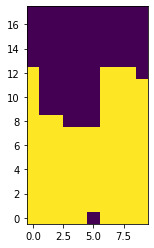

In [793]:
pi_hat = my_policy.get_optimal_policy()
plt.imshow(pi_hat[0], origin='lower')

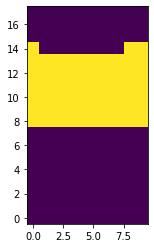

In [794]:
plt.imshow(pi_hat[1], origin='lower')

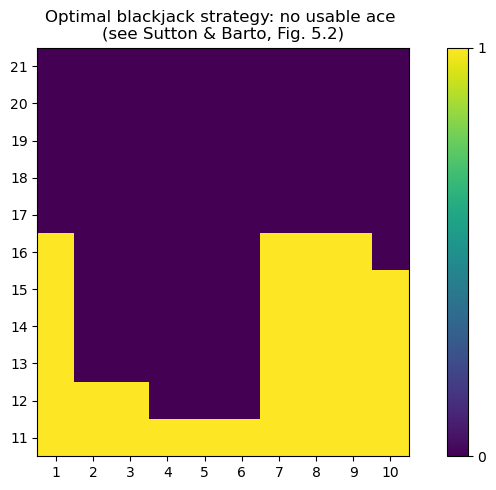

In [835]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

player = range(4,22)
dealer = range(1,11)

policy = pi_hat[0]

fig, ax = plt.subplots()
im = ax.imshow(policy, origin='lower')

# We want to show all ticks...
ax.set_yticks(np.arange(len(player)))
ax.set_xticks(np.arange(len(dealer)))

# ... and label them with the respective list entries
ax.set_yticklabels(player)
ax.set_xticklabels(dealer)

# Loop over data dimensions and create text annotations.
# for i in range(len(player)):
#     for j in range(len(dealer)):
#         text = ax.text(j, i, policy[i, j],
#                        ha="center", va="center", color="r")

ax.set_title("Optimal blackjack strategy: no usable ace \n(see Sutton & Barto, Fig. 5.2)")
ax.set_ylim(6.5,17.5)
fig.tight_layout()
cb = plt.colorbar(im, ticks=[0,1])
plt.show()

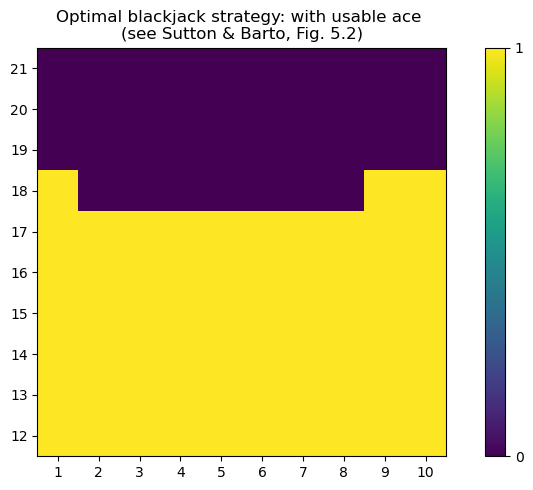

In [836]:

player = range(4,22)
dealer = range(1,11)

policy = pi_hat[1]

fig, ax = plt.subplots()
im = ax.imshow(policy, origin='lower')

# We want to show all ticks...
ax.set_yticks(np.arange(len(player)))
ax.set_xticks(np.arange(len(dealer)))

# ... and label them with the respective list entries
ax.set_yticklabels(player)
ax.set_xticklabels(dealer)

# Loop over data dimensions and create text annotations.
#for i in range(len(player)):
#    for j in range(len(dealer)):
#        text = ax.text(j, i, policy[i, j],
#                       ha="center", va="center", color="r")

ax.set_title("Optimal blackjack strategy: with usable ace \n(see Sutton & Barto, Fig. 5.2)")
ax.set_ylim(7.5,17.5)
fig.tight_layout()
cb = plt.colorbar(im, ticks=[0,1])
plt.show()